### 0. Initizalize Packages

In [79]:
#!pip install scipy,seaborn
import seaborn as sns
from scipy.stats import kstest

import pandas as pd
import numpy as np

#!pip install -U plotly
pd.options.plotting.backend = "plotly"

#!pip3 install nltk
import nltk
from nltk import pos_tag
from nltk import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from nltk.tokenize import word_tokenize, sent_tokenize
from scipy.stats import chi2_contingency

import math
from scipy.stats import shapiro 
from scipy.stats import lognorm
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt

#!pip3 install openpyxl
import openpyxl as px
from statsmodels.stats.weightstats import ztest



### 0.1. Read Dataset ( N = 114)

In [181]:
df = pd.read_excel('all_gpt_human_only_text.xlsx')

### 0.1.1 Preprocess

Get rid of extra white spaces

In [182]:
def strip(dataframe):
    return [s.strip() for s in dataframe]

df= df.apply(strip)

## 1. Pos Tagging with Less Category Separate for Each Sentence

Each story's pos taggings completed separately, and counted for the story itself

### 1.1. Preprocess and Tag

In [183]:
#clean data from stopwords, tokenize it, and tag
punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
stop_words = set(stopwords.words('english'))

def create_tokenized(text):
    tokenized = word_tokenize(text)
    'tag the tokens'
    tagged = nltk.pos_tag(tokenized)
    
    'Removes stopwords after tagging them'
    to_remove = set()
    for i in range(len(tagged)):
        word = tagged[i][0]
        if word.lower() in stop_words:
            to_remove.add(i)
        else:
            pass

        new_tagged = [tagged[i] for i in range(len(tagged)) if i not in to_remove]        

    return new_tagged

In [184]:
## Filter and get words as tokens
for column in df.columns:
    df[f'tokenized_{column}'] = df[column].apply(lambda x: create_tokenized(x))

### 1.2. Count the pos-tags

In [185]:
#count the tags
def count_tags(mydata):
    counter_list=[]
    for i in mydata:
        counter_list.append(i[1])

    tag_counts = Counter(counter_list) 
    return tag_counts

In [186]:
for column in [col for col in df.columns if col.startswith('tokenized_')]:
    df[f'{column}_tag_counts'] = df[column].apply(lambda x: count_tags(x))

### 1.3. Merge relevant categories together

Count tags for all nouns (plural nouns, proper nouns etc.), verbs, adjectives, adverbs, pronouns and prepositions/conjuctions/determiners


In [13]:
for column in [col for col in df.columns if col.endswith('tag_counts')]:
    df[f'{column[:-7]}_noun'] = [*(df[column].apply(lambda x: (x['NN'] + x['NNS'] + x['NNP']+ x['NNPS'])))]
    df[f'{column[:-7]}_verb'] = [*(df[column].apply(lambda x: (x['VB'] + x['VBN'] + x['VBG']+ x['VBZ'] + x['VBP']+x['VBD'])))]
    df[f'{column[:-7]}_adj'] = [*(df[column].apply(lambda x: (x['JJ'] + x['JJS'] + x['JJR'])))]
    df[f'{column[:-7]}_adv'] = [*(df[column].apply(lambda x: (x['RB'] + x['RBR'] + x['WRB'] +x['RBS'])))]
    df[f'{column[:-7]}_pron'] = [*(df[column].apply(lambda x: (x['PRP'] + x['PRP$'] + x['WB']+ x['WB$'])))]
    df[f'{column[:-7]}_con_det_prep'] = [*(df[column].apply(lambda x: (x['DT'] + x['IN'] + x['UH']+ x['TO']+ x['WDT']+ x['EX'])))]
    df[f'{column[:-7]}_prep'] = [*(df[column].apply(lambda x: (x['IN'])))]



In [14]:
df['tokenized_GPT_R3'].apply(lambda x: len(x))
df.tokenized_GPT_R3_tag_noun

0      15
1      12
2      11
3       9
4      10
       ..
111    13
112     7
113    12
114    11
115    11
Name: tokenized_GPT_R3_tag_noun, Length: 116, dtype: int64

## 1.4. Get Ratio of Grammatical Categories to Word Count

In [15]:
cols = [('tokenized_GPT_R3', 'GPT_3'), 
        ('tokenized_GPT_R2', 'GPT_2'), 
        ('tokenized_GPT_R1', 'GPT_1'), 
        ('tokenized_Retell_1', 'Retell_1'), 
        ('tokenized_Retell_2', 'Retell_2'), 
        ('tokenized_Retell_3', 'Retell_3'), 
        ('tokenized_STORY', 'story')]

# Define a list of tuples with the tag types and their corresponding suffixes
tag_types = [('tag_noun', 'noun'), 
             ('tag_verb', 'verb'), 
             ('tag_adj', 'adj'), 
             ('tag_adv', 'adv'), 
             ('tag_con_det_prep', 'con_det_prep'), 
             ('tag_pron', 'pron'), 
             ('tag_prep', 'prep')]

# Loop over each tag type
for tag_type, suffix in tag_types:
    # Loop over each column and calculate the corresponding tag ratio
    for col, col_suffix in cols:
        tag_col = col + '_' + tag_type
        ratio_col = col_suffix + '_' + suffix + '_ratio'
        df[ratio_col] = df[tag_col] / df[col].apply(len)

/var/folders/l4/1xnf5c593754ph42_t0k68480000gq/T/ipykernel_26648/4017749826.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[ratio_col] = df[tag_col] / df[col].apply(len)
/var/folders/l4/1xnf5c593754ph42_t0k68480000gq/T/ipykernel_26648/4017749826.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[ratio_col] = df[tag_col] / df[col].apply(len)
/var/folders/l4/1xnf5c593754ph42_t0k68480000gq/T/ipykernel_26648/4017749826.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fra

### 1.4.1. Carry counts and ratios into different DataFrame

In [16]:
count_ratio = pd.DataFrame

count_ratio= df[['GPT_3_noun_ratio',
 'GPT_2_noun_ratio',
 'GPT_1_noun_ratio',
 'Retell_1_noun_ratio',
 'Retell_2_noun_ratio',
 'Retell_3_noun_ratio',
 'story_noun_ratio',
 'GPT_3_verb_ratio',
 'GPT_2_verb_ratio',
 'GPT_1_verb_ratio',
 'Retell_1_verb_ratio',
 'Retell_2_verb_ratio',
 'Retell_3_verb_ratio',
 'story_verb_ratio',
 'GPT_3_adj_ratio',
 'GPT_2_adj_ratio',
 'GPT_1_adj_ratio',
 'Retell_1_adj_ratio',
 'Retell_2_adj_ratio',
 'Retell_3_adj_ratio',
 'story_adj_ratio',
 'GPT_3_adv_ratio',
 'GPT_2_adv_ratio',
 'GPT_1_adv_ratio',
 'Retell_1_adv_ratio',
 'Retell_2_adv_ratio',
 'Retell_3_adv_ratio',
 'story_adv_ratio',
 'GPT_3_con_det_prep_ratio',
 'GPT_2_con_det_prep_ratio',
 'GPT_1_con_det_prep_ratio',
 'Retell_1_con_det_prep_ratio',
 'Retell_2_con_det_prep_ratio',
 'Retell_3_con_det_prep_ratio',
 'story_con_det_prep_ratio',
 'GPT_3_pron_ratio',
 'GPT_2_pron_ratio',
 'GPT_1_pron_ratio',
 'Retell_1_pron_ratio',
 'Retell_2_pron_ratio',
 'Retell_3_pron_ratio',
 'story_pron_ratio',
 'GPT_3_prep_ratio',
 'GPT_2_prep_ratio',
 'GPT_1_prep_ratio',
 'Retell_1_prep_ratio',
 'Retell_2_prep_ratio',
 'Retell_3_prep_ratio',
 'story_prep_ratio']]

In [17]:
#store counts into a dataframe 
counts = pd.DataFrame()

df_count = df[['tokenized_STORY_tag_noun',
 'tokenized_STORY_tag_verb',
 'tokenized_STORY_tag_adj',
 'tokenized_STORY_tag_adv',
 'tokenized_STORY_tag_pron',
 'tokenized_STORY_tag_con_det_prep',
 'tokenized_STORY_tag_prep',
 'tokenized_GPT_R1_tag_noun',
 'tokenized_GPT_R1_tag_verb',
 'tokenized_GPT_R1_tag_adj',
 'tokenized_GPT_R1_tag_adv',
 'tokenized_GPT_R1_tag_pron',
 'tokenized_GPT_R1_tag_con_det_prep',
 'tokenized_GPT_R1_tag_prep',
 'tokenized_GPT_R2_tag_noun',
 'tokenized_GPT_R2_tag_verb',
 'tokenized_GPT_R2_tag_adj',
 'tokenized_GPT_R2_tag_adv',
 'tokenized_GPT_R2_tag_pron',
 'tokenized_GPT_R2_tag_con_det_prep',
 'tokenized_GPT_R2_tag_prep',
 'tokenized_GPT_R3_tag_noun',
 'tokenized_GPT_R3_tag_verb',
 'tokenized_GPT_R3_tag_adj',
 'tokenized_GPT_R3_tag_adv',
 'tokenized_GPT_R3_tag_pron',
 'tokenized_GPT_R3_tag_con_det_prep',
 'tokenized_GPT_R3_tag_prep',
 'tokenized_Retell_1_tag_noun',
 'tokenized_Retell_1_tag_verb',
 'tokenized_Retell_1_tag_adj',
 'tokenized_Retell_1_tag_adv',
 'tokenized_Retell_1_tag_pron',
 'tokenized_Retell_1_tag_con_det_prep',
 'tokenized_Retell_1_tag_prep',
 'tokenized_Retell_2_tag_noun',
 'tokenized_Retell_2_tag_verb',
 'tokenized_Retell_2_tag_adj',
 'tokenized_Retell_2_tag_adv',
 'tokenized_Retell_2_tag_pron',
 'tokenized_Retell_2_tag_con_det_prep',
 'tokenized_Retell_2_tag_prep',
 'tokenized_Retell_3_tag_noun',
 'tokenized_Retell_3_tag_verb',
 'tokenized_Retell_3_tag_adj',
 'tokenized_Retell_3_tag_adv',
 'tokenized_Retell_3_tag_pron',
 'tokenized_Retell_3_tag_con_det_prep',
 'tokenized_Retell_3_tag_prep']

]

Our dataframes are:

1-count = df_count
2- ratio = count_ratio

### 1.5. Significance Test Between Retellings (Counts of Words)

In [18]:
mannwhitneyu(df_count['tokenized_GPT_R3_tag_con_det_prep'], df_count['tokenized_Retell_3_tag_con_det_prep']) #significant

MannwhitneyuResult(statistic=5917.0, pvalue=0.041110994337190315)

In [19]:
shapiro(df_count) #data is not normal, so we will use Mann-u Whitney

/Users/eotenen/mambaforge/lib/python3.10/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.6976909637451172, pvalue=0.0)

In [20]:
tags = ['noun', 'verb', 'adj', 'adv', 'pron', 'con_det_prep', 'prep']

for tag in tags:
    for i in range(1, 4):
        gpt_tag = f"tokenized_GPT_R{i}_tag_{tag}"
        retell_tag = f"tokenized_Retell_{i}_tag_{tag}"
        
        p_value = mannwhitneyu(df_count[gpt_tag], df_count[retell_tag])[1]
        if p_value < 0.05:
            print(f"{tag.capitalize()}s in GPT_R{i} and Retell_{i} are significantly different (p-value={p_value:.3f}), gpt= {df_count[gpt_tag].mean()}, human= {df_count[retell_tag].mean()}.")
        else:
            print(f"{tag.capitalize()}s in GPT_R{i} and Retell_{i} are not significantly different (p-value={p_value:.3f}), gpt= {df_count[gpt_tag].mean()}, human= {df_count[retell_tag].mean()}.")
    print("")

Nouns in GPT_R1 and Retell_1 are significantly different (p-value=0.020), gpt= 13.28448275862069, human= 15.793103448275861.
Nouns in GPT_R2 and Retell_2 are not significantly different (p-value=0.814), gpt= 11.741379310344827, human= 12.120689655172415.
Nouns in GPT_R3 and Retell_3 are significantly different (p-value=0.000), gpt= 10.655172413793103, human= 9.422413793103448.

Verbs in GPT_R1 and Retell_1 are significantly different (p-value=0.000), gpt= 7.974137931034483, human= 10.862068965517242.
Verbs in GPT_R2 and Retell_2 are significantly different (p-value=0.015), gpt= 6.577586206896552, human= 8.120689655172415.
Verbs in GPT_R3 and Retell_3 are not significantly different (p-value=0.581), gpt= 5.956896551724138, human= 6.603448275862069.

Adjs in GPT_R1 and Retell_1 are significantly different (p-value=0.014), gpt= 3.3017241379310347, human= 4.112068965517241.
Adjs in GPT_R2 and Retell_2 are not significantly different (p-value=0.409), gpt= 3.0344827586206895, human= 2.879310

### 1.6. Visualize Counts

Prepare dataset accordingly

In [21]:
count_means = pd.DataFrame()
count_means['mean'] = [*df_count.mean()]
count_means['gen']= ['origin','origin','origin','origin','origin','origin','origin','GPT_R1','GPT_R1','GPT_R1','GPT_R1','GPT_R1','GPT_R1','GPT_R1','GPT_R2','GPT_R2','GPT_R2','GPT_R2','GPT_R2','GPT_R2','GPT_R2','GPT_R3','GPT_R3','GPT_R3','GPT_R3','GPT_R3','GPT_R3','GPT_R3','Retell_1','Retell_1','Retell_1','Retell_1','Retell_1','Retell_1','Retell_1','Retell_2','Retell_2','Retell_2','Retell_2','Retell_2','Retell_2','Retell_2','Retell_3','Retell_3','Retell_3','Retell_3','Retell_3','Retell_3','Retell_3']
count_means['type']= ['noun','verb','adj','adv','pron','con_det_prep','prep','noun','verb','adj','adv','pron','con_det_prep','prep','noun','verb','adj','adv','pron','con_det_prep','prep','noun','verb','adj','adv','pron','con_det_prep','prep','noun','verb','adj','adv','pron','con_det_prep','prep','noun','verb','adj','adv','pron','con_det_prep','prep','noun','verb','adj','adv','pron','con_det_prep','prep']


#### 1.6.1. First Generation 

[Text(0.5, 1.0, 'Mean of Grammatical Categories')]

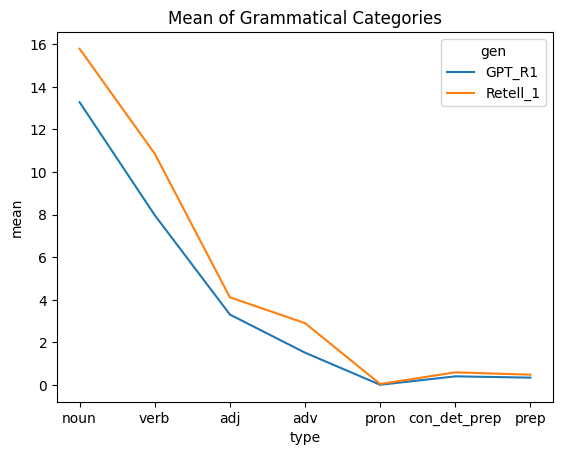

In [22]:
first_gen = count_means.loc[count_means['gen'].isin(['GPT_R1', 'Retell_1'])]

sns.lineplot(data=first_gen, x="type", y="mean", hue="gen").set(title='Mean of Grammatical Categories')


#### 1.6.2. Second Generation 

[Text(0.5, 1.0, 'Mean of Grammatical Categories')]

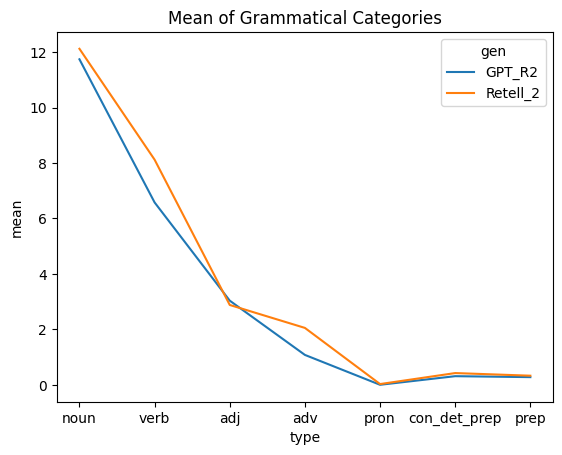

In [23]:
second_gen = count_means.loc[count_means['gen'].isin(['GPT_R2', 'Retell_2'])]

sns.lineplot(data=second_gen, x="type", y="mean", hue="gen").set(title='Mean of Grammatical Categories')


#### 1.6.3. Third Generation 

[Text(0.5, 1.0, 'Mean of Grammatical Categories')]

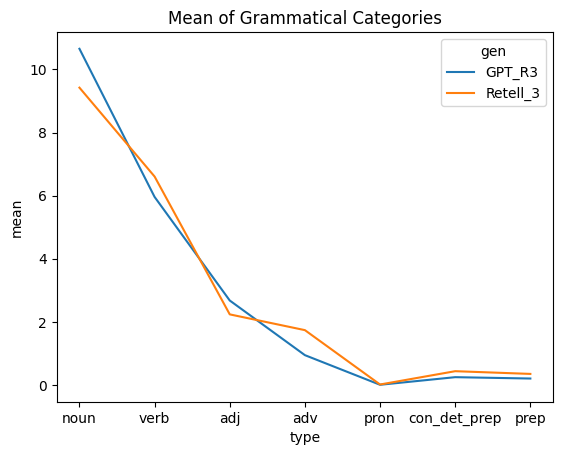

In [24]:
third_gen = count_means.loc[count_means['gen'].isin(['GPT_R3', 'Retell_3'])]

sns.lineplot(data=third_gen, x="type", y="mean", hue="gen").set(title='Mean of Grammatical Categories')


#### 1.6.4. All Together

<Axes: xlabel='type', ylabel='mean'>

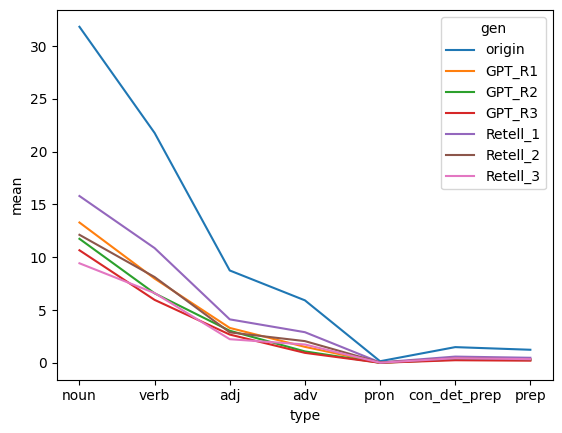

In [25]:
sns.lineplot(data=count_means, x="type", y="mean", hue="gen")


<Axes: xlabel='gen', ylabel='mean'>

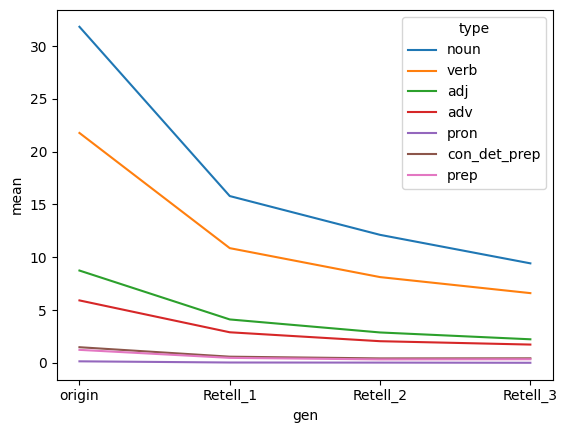

In [26]:
human = count_means.loc[count_means['gen'].isin(['origin','Retell_1', 'Retell_2','Retell_3'])]

sns.lineplot(data=human, x="gen", y="mean", hue="type")

<Axes: xlabel='gen', ylabel='mean'>

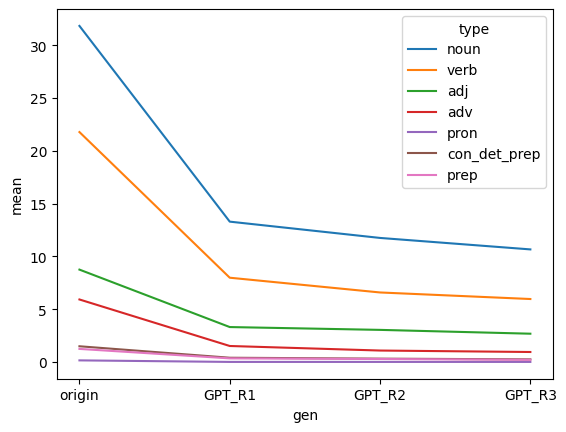

In [27]:
gpt = count_means.loc[count_means['gen'].isin(['origin','GPT_R1', 'GPT_R2','GPT_R3'])]

sns.lineplot(data=gpt, x="gen", y="mean", hue="type")

### 1.7. Statistical Test for Ratios

In [28]:
ztest(x1=count_ratio.Retell_3_prep_ratio, x2=count_ratio.GPT_3_prep_ratio, value=0) 

(1.7926179463951941, 0.07303403480938406)

In [29]:
#!pip3 install statsmodels
#Because the values are proportions, I conducted a z-test analysis 

import statsmodels.api as sm

# create a list of tuples for each POS category
pos_categories = [('noun', 'Retell_1_noun_ratio', 'GPT_1_noun_ratio'),
                  ('noun', 'Retell_2_noun_ratio', 'GPT_2_noun_ratio'),
                  ('noun', 'Retell_3_noun_ratio', 'GPT_3_noun_ratio'),
                  ('verb', 'Retell_1_verb_ratio', 'GPT_1_verb_ratio'),
                  ('verb', 'Retell_2_verb_ratio', 'GPT_2_verb_ratio'),
                  ('verb', 'Retell_3_verb_ratio', 'GPT_3_verb_ratio'),
                  ('adj', 'Retell_1_adj_ratio', 'GPT_1_adj_ratio'),
                  ('adj', 'Retell_2_adj_ratio', 'GPT_2_adj_ratio'),
                  ('adj', 'Retell_3_adj_ratio', 'GPT_3_adj_ratio'),
                  ('adv', 'Retell_1_adv_ratio', 'GPT_1_adv_ratio'),
                  ('adv', 'Retell_2_adv_ratio', 'GPT_2_adv_ratio'),
                  ('adv', 'Retell_3_adv_ratio', 'GPT_3_adv_ratio'),
                  ('pron', 'Retell_1_pron_ratio', 'GPT_1_pron_ratio'),
                  ('pron', 'Retell_2_pron_ratio', 'GPT_2_pron_ratio'),
                  ('pron', 'Retell_3_pron_ratio', 'GPT_3_pron_ratio'),
                  ('det_con_prep', 'Retell_1_con_det_prep_ratio', 'GPT_1_con_det_prep_ratio'),
                  ('det_con_prep', 'Retell_2_con_det_prep_ratio', 'GPT_2_con_det_prep_ratio'),
                  ('det_con_prep', 'Retell_3_con_det_prep_ratio', 'GPT_3_con_det_prep_ratio'),
                  ('prep', 'Retell_1_prep_ratio', 'GPT_1_prep_ratio'),
                  ('prep', 'Retell_2_prep_ratio', 'GPT_2_prep_ratio'),
                  ('prep', 'Retell_3_prep_ratio', 'GPT_3_prep_ratio')]

# loop through the list of tuples and conduct the z-tests
for pos_category in pos_categories:
    pos = pos_category[0]
    x1 = pos_category[1]
    x2 = pos_category[2]
    
    print(f" Analysis of {pos}")
    ztest, pval = sm.stats.ztest(count_ratio[x1], count_ratio[x2], value=0)
    if pval < 0.05:
        print(f"Significant difference in {pos} between {[x1], [x2], pval}")
    else:
        print(f"No difference in {pos} {[x1], [x2], pval}")


 Analysis of noun
Significant difference in noun between (['Retell_1_noun_ratio'], ['GPT_1_noun_ratio'], 0.0030422811017619274)
 Analysis of noun
Significant difference in noun between (['Retell_2_noun_ratio'], ['GPT_2_noun_ratio'], 0.011625506578566373)
 Analysis of noun
Significant difference in noun between (['Retell_3_noun_ratio'], ['GPT_3_noun_ratio'], 9.792795015637258e-05)
 Analysis of verb
No difference in verb (['Retell_1_verb_ratio'], ['GPT_1_verb_ratio'], 0.8353822209560913)
 Analysis of verb
No difference in verb (['Retell_2_verb_ratio'], ['GPT_2_verb_ratio'], 0.1955448970443736)
 Analysis of verb
Significant difference in verb between (['Retell_3_verb_ratio'], ['GPT_3_verb_ratio'], 0.022301841804994692)
 Analysis of adj
No difference in adj (['Retell_1_adj_ratio'], ['GPT_1_adj_ratio'], 0.5417028414469971)
 Analysis of adj
Significant difference in adj between (['Retell_2_adj_ratio'], ['GPT_2_adj_ratio'], 0.0356214655126636)
 Analysis of adj
Significant difference in adj be

RESULTS:


### 1.7.1. Visualize Ratios

In [30]:
ratio_means = pd.DataFrame()
ratio_means['mean'] = [*count_ratio.mean()]
ratio_means['gen']= ['GPT_3', 'GPT_2','GPT_1', 'Retell_1','Retell_2','Retell_3','origin','GPT_3', 'GPT_2','GPT_1', 'Retell_1','Retell_2','Retell_3','origin','GPT_3', 'GPT_2','GPT_1', 'Retell_1','Retell_2','Retell_3','origin','GPT_3', 'GPT_2','GPT_1', 'Retell_1','Retell_2','Retell_3','origin','GPT_3', 'GPT_2','GPT_1', 'Retell_1','Retell_2','Retell_3','origin','GPT_3', 'GPT_2','GPT_1', 'Retell_1','Retell_2','Retell_3','origin','GPT_3', 'GPT_2','GPT_1', 'Retell_1','Retell_2','Retell_3','origin']
ratio_means['type']= ['noun','noun','noun','noun','noun','noun','noun','verb','verb','verb','verb','verb','verb','verb','adj','adj','adj','adj','adj','adj','adj','adv','adv','adv','adv','adv','adv','adv','con_det_prep','con_det_prep','con_det_prep','con_det_prep','con_det_prep','con_det_prep','con_det_prep','pron','pron','pron','pron','pron','pron','pron','prep','prep','prep','prep','prep','prep','prep']


#### 1.7.1.1. First Gen

[Text(0.5, 1.0, 'Ratio of Grammatical Categories')]

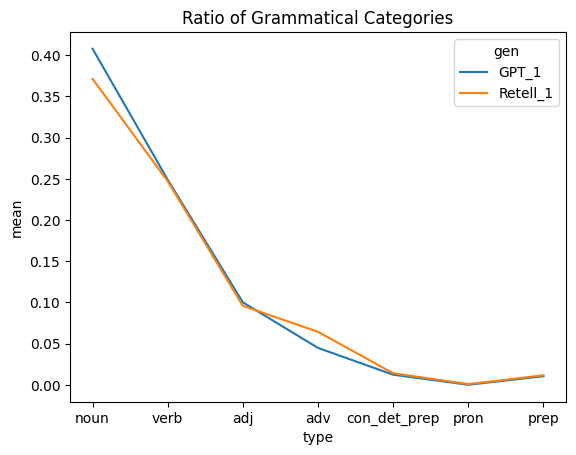

In [31]:
first_gen = ratio_means.loc[ratio_means['gen'].isin(['GPT_1', 'Retell_1'])]

sns.lineplot(data=first_gen, x="type", y="mean", hue="gen").set(title='Ratio of Grammatical Categories')


#### 1.7.1.2. Second Generation


[Text(0.5, 1.0, 'Ratio of Grammatical Categories')]

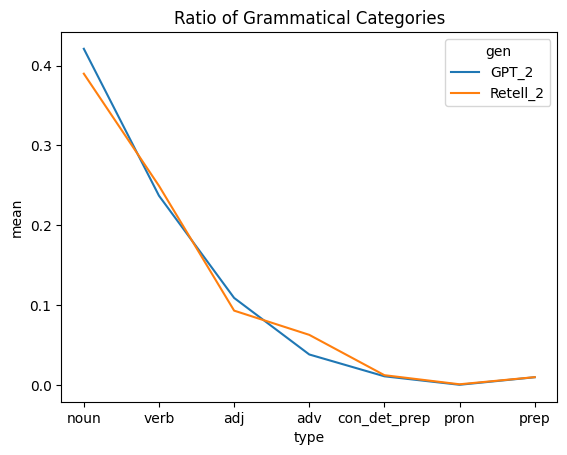

In [32]:
second_gen = ratio_means.loc[ratio_means['gen'].isin(['GPT_2', 'Retell_2'])]

sns.lineplot(data=second_gen, x="type", y="mean", hue="gen").set(title='Ratio of Grammatical Categories')


#### 1.7.1.3. Second Generation


[Text(0.5, 1.0, 'Ratio of Grammatical Categories')]

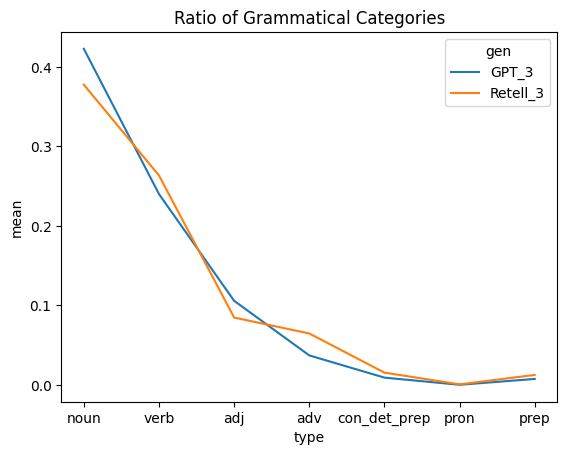

In [33]:
third_gen = ratio_means.loc[ratio_means['gen'].isin(['GPT_3', 'Retell_3'])]

sns.lineplot(data=third_gen, x="type", y="mean", hue="gen").set(title='Ratio of Grammatical Categories')


#### 1.7.1.4. All Together

<Axes: xlabel='type', ylabel='mean'>

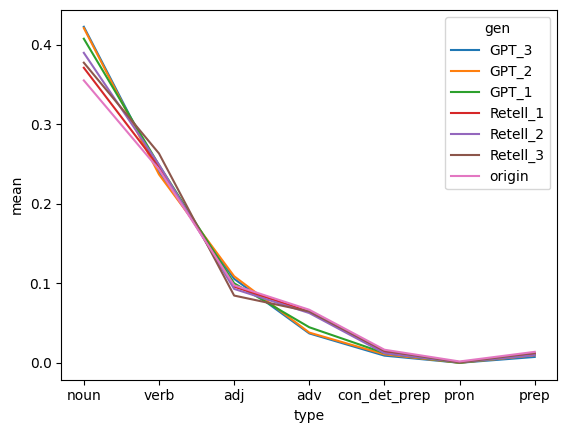

In [34]:
sns.lineplot(data=ratio_means, x="type", y="mean", hue="gen")


<Axes: xlabel='gen', ylabel='mean'>

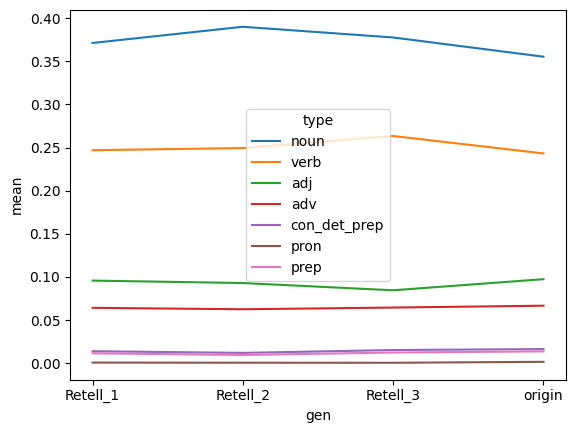

In [35]:
human = ratio_means.loc[ratio_means['gen'].isin(['origin','Retell_1', 'Retell_2','Retell_3'])]
sns.lineplot(data=human, x="gen", y="mean", hue="type")

<Axes: xlabel='gen', ylabel='mean'>

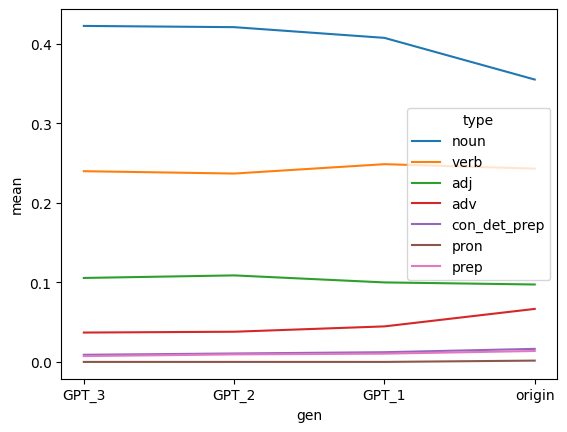

In [36]:
gpt = ratio_means.loc[ratio_means['gen'].isin(['origin','GPT_1', 'GPT_2','GPT_3',])]

sns.lineplot(data=gpt, x="gen", y="mean", hue="type")

### 1.8. Calculate Verb-Adv and Noun-Adj Ratios

In [37]:
#Adverb-verb ratio
df['story_adv_to_verb_ratio']= df.tokenized_STORY_tag_adv/df.tokenized_STORY_tag_verb
df['Retell_1_adv_to_verb_ratio']= df.tokenized_Retell_1_tag_adv/df.tokenized_Retell_1_tag_verb
df['Retell_2_adv_to_verb_ratio']= df.tokenized_Retell_2_tag_adv/df.tokenized_Retell_2_tag_verb
df['Retell_3_adv_to_verb_ratio']= df.tokenized_Retell_3_tag_adv/df.tokenized_Retell_3_tag_verb
df['GPT_1_adv_to_verb_ratio']= df.tokenized_GPT_R1_tag_adv/df.tokenized_GPT_R1_tag_verb
df['GPT_2_adv_to_verb_ratio']= df.tokenized_GPT_R2_tag_adv/df.tokenized_GPT_R2_tag_verb
df['GPT_3_adv_to_verb_ratio']= df.tokenized_GPT_R3_tag_adv/df.tokenized_GPT_R3_tag_verb

#Adjective-noun ratio
df['story_adj_to_noun_ratio']= df.tokenized_STORY_tag_adj/df.tokenized_STORY_tag_noun
df['Retell_1_adj_to_noun_ratio']= df.tokenized_Retell_1_tag_adj/df.tokenized_Retell_1_tag_noun
df['Retell_2_adj_to_noun_ratio']= df.tokenized_Retell_2_tag_adj/df.tokenized_Retell_2_tag_noun
df['Retell_3_adj_to_noun_ratio']= df.tokenized_Retell_3_tag_adj/df.tokenized_Retell_3_tag_noun
df['GPT_1_adj_to_noun_ratio']= df.tokenized_GPT_R1_tag_adj/df.tokenized_GPT_R1_tag_noun
df['GPT_2_adj_to_noun_ratio']= df.tokenized_GPT_R2_tag_adj/df.tokenized_GPT_R2_tag_noun
df['GPT_3_adj_to_noun_ratio']= df.tokenized_GPT_R3_tag_adj/df.tokenized_GPT_R3_tag_noun

### 1.8.2. Visualize Adb/Verb Adj/Noun Ratios


#### 1.8.2.1. Prepare dataset to visualize

In [38]:
verbnoun_ratio = df[['story_adv_to_verb_ratio',
 'Retell_1_adv_to_verb_ratio',
 'Retell_2_adv_to_verb_ratio',
 'Retell_3_adv_to_verb_ratio',
 'GPT_1_adv_to_verb_ratio',
 'GPT_2_adv_to_verb_ratio',
 'GPT_3_adv_to_verb_ratio',
 'story_adj_to_noun_ratio',
 'Retell_1_adj_to_noun_ratio',
 'Retell_2_adj_to_noun_ratio',
 'Retell_3_adj_to_noun_ratio',
 'GPT_1_adj_to_noun_ratio',
 'GPT_2_adj_to_noun_ratio',
 'GPT_3_adj_to_noun_ratio']]

In [39]:
verbnoun_means = pd.DataFrame()
verbnoun_means['mean'] = [*verbnoun_ratio.mean()]

In [40]:
verbnoun_means['gen'] = ['story','first','second','third','first','second','third','story','first','second','third','first','second','third']
verbnoun_means['type'] = ['origin','human','human','human','gpt','gpt','gpt','origin','human','human','human','gpt','gpt','gpt']
verbnoun_means['ratio'] = ['adv_verb','adv_verb','adv_verb','adv_verb','adv_verb','adv_verb','adv_verb','adj_noun','adj_noun','adj_noun','adj_noun','adj_noun','adj_noun','adj_noun']


[Text(0.5, 1.0, 'Adverb to Verb Ratio (Significant All)')]

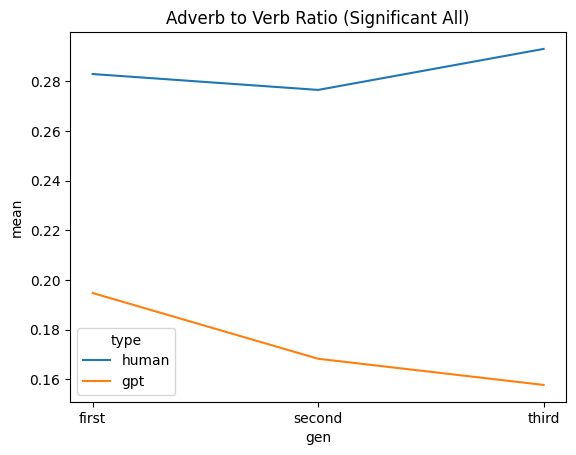

In [41]:
# Adverb to Verb
verbnoun = verbnoun_means.loc[verbnoun_means['type'].isin(['human','gpt']) & verbnoun_means['ratio'].isin(['adv_verb']) ]

sns.lineplot(data=verbnoun, x="gen", y="mean", hue="type").set(title='Adverb to Verb Ratio (Significant All)')


[Text(0.5, 1.0, 'Adjective to Noun Ratio (Significant at First)')]

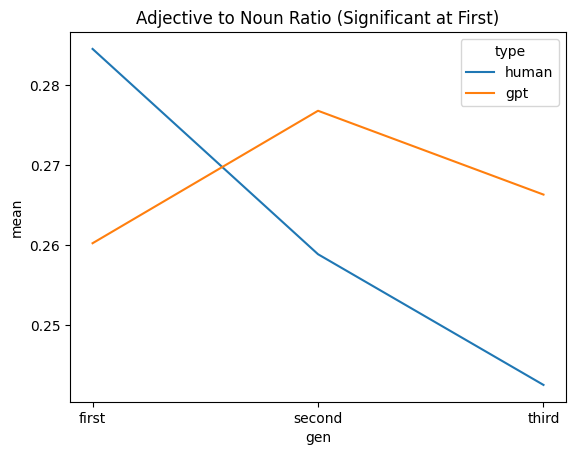

In [42]:
# Adjective to Noun 
verbnoun = verbnoun_means.loc[verbnoun_means['type'].isin(['human','gpt']) & verbnoun_means['ratio'].isin(['adj_noun']) ]

sns.lineplot(data=verbnoun, x="gen", y="mean", hue="type").set(title='Adjective to Noun Ratio (Significant at First)')


### 1.8.1. Statistical Test for Adv/verb Adj/noun ratios

In [43]:
ztest(x1=df.Retell_3_adj_to_noun_ratio, x2=df.GPT_3_adj_to_noun_ratio, value=0) 

TypeError: 'numpy.float64' object is not callable

In [ ]:
ztest(x1=df.Retell_2_adj_to_noun_ratio, x2=df.GPT_2_adj_to_noun_ratio, value=0) 


In [ ]:
#Adverb to verb
ztest(x1=df.Retell_1_adv_to_verb_ratio, x2=df.GPT_1_adv_to_verb_ratio, value=0) #significant
ztest(x1=df.Retell_2_adv_to_verb_ratio, x2=df.GPT_2_adv_to_verb_ratio, value=0) #significant
ztest(x1=df.Retell_3_adv_to_verb_ratio, x2=df.GPT_3_adv_to_verb_ratio, value=0) #significant



RESULTS


## 2. Pos-Tagging for Overall

This time all taggings are summed together regardless of their story

### 2.1. Preprocess, Tag, Flatten (Get Rid of Stopwords)

In [ ]:
def create_tokenized(text):
    tokenized = word_tokenize(text)
    'tag the tokens'
    tagged = nltk.pos_tag(tokenized)
    
    'Removes stopwords after tagging them'
    to_remove = set()
    for i in range(len(tagged)):
        word = tagged[i][0]
        if word.lower() in stop_words:
            to_remove.add(i)
        else:
            pass

        new_tagged = [tagged[i] for i in range(len(tagged)) if i not in to_remove]        

    return new_tagged

In [193]:
def small_post_tagger(dataframe):
    from nltk.tokenize import word_tokenize, sent_tokenize
    stop_words = set(stopwords.words('english'))

    story_part_tags = []
    punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''

    for text in dataframe:
        for ele in text:
            if ele in punc:
                text = text.replace(ele, "")

        tokenized = word_tokenize(text)
        for i in tokenized:

            # Word tokenizers is used to find the words
            # and punctuation in a string
            wordsList = nltk.word_tokenize(i)
            tagged = nltk.pos_tag(wordsList)
            
            to_remove = set()
            for i in range(len(tagged)):
                word = tagged[i][0]
                if word.lower() in stop_words:
                    to_remove.add(i)
                else:
                    pass

                new_tagged = [tagged[i] for i in range(len(tagged)) if i not in to_remove]  


            story_part_tags.append(new_tagged)
    return story_part_tags

In [194]:
# Tag small 
story_part_tags_short = small_post_tagger(df['STORY'])
Retell_1_tags_short = small_post_tagger(df['Retell_1'])
Retell_2_tags_short = small_post_tagger(df['Retell_2'])
Retell_3_tags_short = small_post_tagger(df['Retell_3'])
GPT_R1_tags_short = small_post_tagger(df['GPT_R1'])
GPT_R2_tags_short = small_post_tagger(df['GPT_R2'])
GPT_R3_tags_short = small_post_tagger(df['GPT_R3'])


In [195]:
GPT_R3_tags_short

[[],
 [('high', 'JJ')],
 [('school', 'NN')],
 [('teacher', 'NN')],
 [('received', 'VBN')],
 [],
 [('friend', 'NN')],
 [('request', 'NN')],
 [],
 [('Facebook', 'NN')],
 [],
 [('two', 'CD')],
 [('former', 'JJ')],
 [('students', 'NNS')],
 [('Deeps', 'NNS')],
 [],
 [('Sravs', 'NN')],
 [],
 [('invited', 'VBN')],
 [],
 [],
 [],
 [('thanksgiving', 'VBG')],
 [('dinner', 'NN')],
 [],
 [],
 [('attended', 'VBD')],
 [],
 [('brought', 'NN')],
 [('gifts', 'NNS')],
 [],
 [],
 [],
 [('reunion', 'NN')],
 [('brought', 'NN')],
 [('back', 'RB')],
 [('fond', 'NN')],
 [('memories', 'NNS')],
 [],
 [('emotions', 'NNS')],
 [],
 [],
 [('teacher', 'NN')],
 [('Abigail', 'NN')],
 [('baked', 'VBN')],
 [],
 [('chocolate', 'NN')],
 [('cake', 'NN')],
 [],
 [('improve', 'VB')],
 [],
 [('mood', 'NN')],
 [],
 [('gave', 'VBD')],
 [],
 [('slice', 'NN')],
 [],
 [],
 [('neighbor', 'NN')],
 [('Arthur', 'NNP')],
 [],
 [('cake', 'NN')],
 [],
 [('tasty', 'NN')],
 [],
 [],
 [('made', 'VBN')],
 [],
 [],
 [('happy', 'JJ')],
 [('Art

In [196]:
#Flatten 
story_part_tags_short = [item for sublist in story_part_tags_short for item in sublist]
Retell_1_tags_short = [item for sublist in Retell_1_tags_short for item in sublist]
Retell_2_tags_short = [item for sublist in Retell_2_tags_short for item in sublist]
Retell_3_tags_short = [item for sublist in Retell_3_tags_short for item in sublist]
GPT_R1_tags_short = [item for sublist in GPT_R1_tags_short for item in sublist]
GPT_R2_tags_short = [item for sublist in GPT_R2_tags_short for item in sublist]
GPT_R3_tags_short = [item for sublist in GPT_R3_tags_short for item in sublist]

In [198]:
story_part_tags_short

[('school', 'NN'),
 ('teacher', 'NN'),
 ('taught', 'NN'),
 ('high', 'JJ'),
 ('school', 'NN'),
 ('Kids', 'NNS'),
 ('looking', 'VBG'),
 ('Facebook', 'NN'),
 ('app', 'NN'),
 ('iPhone', 'NN'),
 ('sees', 'NNS'),
 ('friend', 'NN'),
 ('request', 'NN'),
 ('two', 'CD'),
 ('ladies', 'NNS'),
 ('name', 'NN'),
 ('Deeps', 'NNS'),
 ('Sravs', 'NN'),
 ('took', 'VBD'),
 ('recollect', 'NN'),
 ('ladies', 'NNS'),
 ('two', 'CD'),
 ('ladies', 'NNS'),
 ('thirties', 'NNS'),
 ('seem', 'NN'),
 ('small', 'JJ'),
 ('family', 'NN'),
 ('depicted', 'VBN'),
 ('profile', 'NN'),
 ('picture', 'NN'),
 ('school', 'NN'),
 ('teacher', 'NN'),
 ('accepted', 'JJ'),
 ('friend', 'NN'),
 ('request', 'NN'),
 ('glad', 'NN'),
 ('see', 'VB'),
 ('Deep', 'JJ'),
 ('Sravs', 'NN'),
 ('long', 'RB'),
 ('time', 'NN'),
 ('minutes', 'NNS'),
 ('gets', 'VBZ'),
 ('call', 'NN'),
 ('surprised', 'JJ'),
 ('know', 'VB'),
 ('Deep', 'JJ'),
 ('Sravs', 'NN'),
 ('come', 'VB'),
 ('home', 'NN'),
 ('thanks', 'NNS'),
 ('giving', 'VBG'),
 ('dinner', 'NN'),
 ('inv

### 2.2. Count Tags

In [199]:
def count_tags(mydata):
    counter_list=[]
    for i in mydata:
        counter_list.append(i[1])

    tag_counts = Counter(counter_list) 
    return tag_counts

In [200]:
# Short tags

story_part_tags_short = count_tags(story_part_tags_short)
GPT_R1_tag_counts_short = count_tags(GPT_R1_tags_short)
GPT_R2_tag_counts_short = count_tags(GPT_R2_tags_short)
GPT_R3_tag_counts_short = count_tags(GPT_R3_tags_short)

Retell_1_tag_counts_short = count_tags(Retell_1_tags_short)
Retell_2_tag_counts_short = count_tags(Retell_2_tags_short)
Retell_3_tag_counts_short = count_tags(Retell_3_tags_short)

### Tags:

CC: It is the conjunction of coordinating

CD: It is a digit of cardinal

DT: It is the determiner

EX: Existential

FW: It is a foreign word

IN: Preposition and conjunction

JJ: Adjective

JJR and JJS: Adjective and superlative

LS: List marker

MD: Modal

NN: Singular noun

NNS, NNP, NNPS: Proper and plural noun

PDT: Predeterminer

WRB: Adverb of wh

WP$: Possessive wh

WP: Pronoun of wh

WDT: Determiner of wp
VBZ: Verb

VBP, VBN, VBG, VBD, VB: Forms of verbs

UH: Interjection


TO: To go

RP: Particle

RBS, RB, RBR: Adverb

PRP, PRP$: Pronoun personal and professional

### 2.3. Visualize

#### 2.3.1. First Retelling

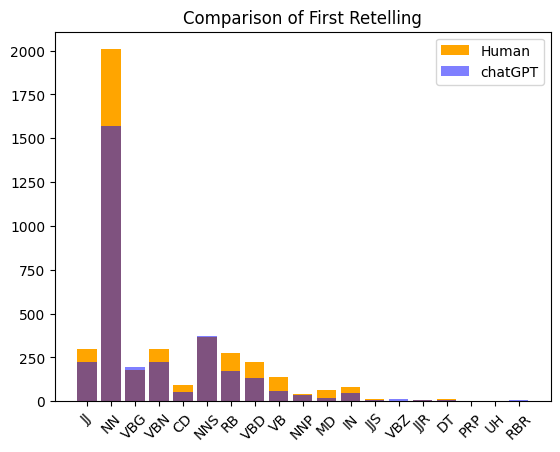

In [201]:
#Human retellings
keys = Retell_1_tag_counts_short.keys()
plt.bar(keys, Retell_1_tag_counts_short.values(), color='orange', label='Human')

#GPT retellings 
keysgpt=GPT_R1_tag_counts_short.keys()
plt.bar(keysgpt, GPT_R1_tag_counts_short.values(),color='blue', label ='chatGPT',alpha = .5)
plt.xticks(rotation=45)  #rotate x labels prevent the overlap
plt.legend(loc='upper right')
plt.title('Comparison of First Retelling')
plt.show()


#### 2.3.2. Second Retelling

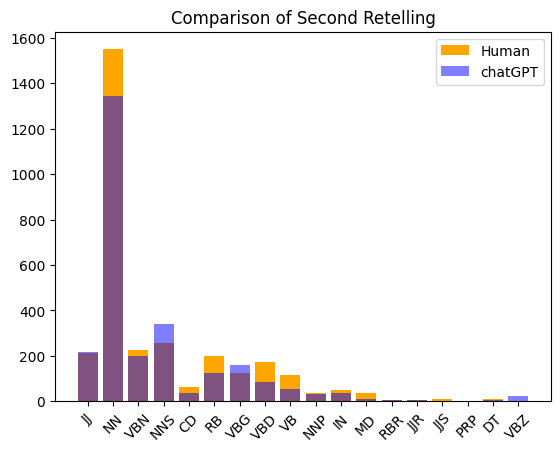

In [225]:
#Human retellings
keys = Retell_2_tag_counts_short.keys()
plt.bar(keys, Retell_2_tag_counts_short.values(), color='orange', label='Human')

#GPT retellings 
keysgpt=GPT_R2_tag_counts_short.keys()
plt.bar(keysgpt, GPT_R2_tag_counts_short.values(),color='blue', label ='chatGPT',alpha = .5)
plt.xticks(rotation=45)  #rotate x labels prevent the overlap
plt.legend(loc='upper right')
plt.title('Comparison of Second Retelling')
plt.show()

#### 2.3.3. Third Retelling

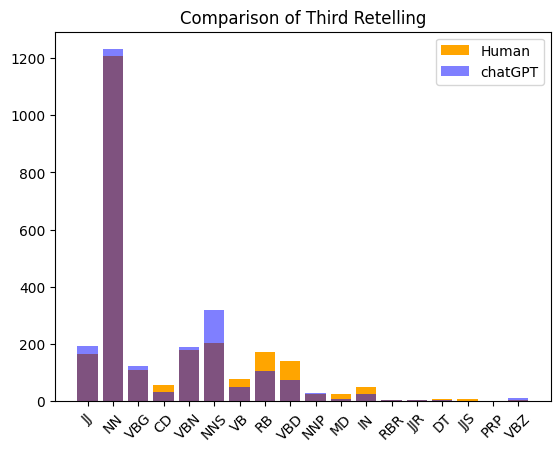

In [226]:
#Human retellings
keys = Retell_3_tag_counts_short.keys()
plt.bar(keys, Retell_3_tag_counts_short.values(), color='orange', label='Human')

#GPT retellings 
keysgpt=GPT_R3_tag_counts_short.keys()
plt.bar(keysgpt, GPT_R3_tag_counts_short.values(),color='blue', label ='chatGPT',alpha = .5)
plt.xticks(rotation=45)  #rotate x labels prevent the overlap
plt.legend(loc='upper right')
plt.title('Comparison of Third Retelling')
plt.show()

## 3. Pos-tagging for Less Category

Only noun,verb,adj,adv,pronoun, and conj/deter/prepositions

### 3.1. Change data format

In [227]:
#Change data format
origin = pd.DataFrame.from_dict(story_part_tags_short,orient='index').reset_index()
origin.columns = ['pos', 'origin']

rt1 = pd.DataFrame.from_dict(Retell_1_tag_counts_short,orient='index').reset_index()
rt1.columns = ['pos', 'rt1']

rt2 = pd.DataFrame.from_dict(Retell_2_tag_counts_short,orient='index').reset_index()
rt2.columns = ['pos', 'rt2']

rt3 = pd.DataFrame.from_dict(Retell_3_tag_counts_short,orient='index').reset_index()
rt3.columns = ['pos', 'rt3']

gpt1 = pd.DataFrame.from_dict(GPT_R1_tag_counts_short,orient='index').reset_index()
gpt1.columns = ['pos', 'gpt1']

gpt2 = pd.DataFrame.from_dict(GPT_R2_tag_counts_short,orient='index').reset_index()
gpt2.columns = ['pos', 'gpt2']

gpt3 = pd.DataFrame.from_dict(GPT_R3_tag_counts_short,orient='index').reset_index()
gpt3.columns = ['pos', 'gpt3']


In [228]:
import functools as ft

#merge dfs
dfs = [origin,rt1,rt2,rt3,gpt1,gpt2,gpt3]
df_final = ft.reduce(lambda left, right: pd.merge(left, right, on='pos',how='outer'), dfs)

#if a category is missing replace with zero
df_final.fillna(0, inplace=True)

#change floats to integer
df_final = df_final.astype({'rt1': int, 'rt2':int, 'rt3':int, 'origin':int, 'gpt1':int, 'gpt2':int, 'gpt3':int})


### 3.2. Merge relevant groups 

In [229]:
pivot = pd.pivot_table(df_final,index='pos', aggfunc=np.sum).transpose()
pivot.columns

Index(['CD', 'DT', 'IN', 'JJ', 'JJR', 'JJS', 'MD', 'NN', 'NNP', 'NNS', 'PRP',
       'RB', 'RBR', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBZ', 'WP$'],
      dtype='object', name='pos')

In [222]:
pivot['NUMBERS'] = pivot['CD']

In [235]:
pivot['VERBS'] = pivot['VB'] + pivot['VBN'] + pivot['VBG']+pivot['VBZ'] + pivot['VBD']
pivot['NOUNS'] = pivot['NN'] + pivot['NNS'] + pivot['NNP']#+ pivot['NNPS']
pivot['ADJECTIVES'] = pivot['JJ'] + pivot['JJS'] + pivot['JJR']
pivot['ADVERBS'] = pivot['RB'] + pivot['RBR'] 
pivot['PRONOUN'] = pivot['PRP'] +pivot['WP$']
pivot['PREPOSITION'] = pivot['IN'] 
pivot['CONJUNCTIONS_DETERMINERS_PREPOSITIONS'] =pivot['DT'] + pivot['IN'] + pivot['UH']

In [236]:
pivot_short = pivot[['VERBS','NOUNS','ADJECTIVES','ADVERBS','PRONOUN','PREPOSITION','CONJUNCTIONS_DETERMINERS_PREPOSITIONS']].reset_index()

In [237]:
Human = pivot_short[(pivot_short['index']=='origin') | (pivot_short['index']=='rt1') |( pivot_short['index']=='rt2')| (pivot_short['index']=='rt3')]
GPT = pivot_short[(pivot_short['index']=='origin') | (pivot_short['index']=='gpt1') |( pivot_short['index']=='gpt2')| (pivot_short['index']=='gpt3')]
   

In [238]:
GPT = GPT.set_index(['index']).reindex(["origin","gpt1","gpt2","gpt3"]).reset_index()

In [239]:
Human.columns =['GENERATION', 'VERBS', 'NOUNS', 'ADJECTIVES', 'ADVERBS', 'PRONOUN','PREPOSITION',
       'CONJUNCTIONS_DETERMINERS_PREPOSITIONS']
GPT.columns =['GENERATION', 'VERBS', 'NOUNS', 'ADJECTIVES', 'ADVERBS', 'PRONOUN','PREPOSITION',
       'CONJUNCTIONS_DETERMINERS_PREPOSITIONS']

### 3.3. Visualize

<function matplotlib.pyplot.show(close=None, block=None)>

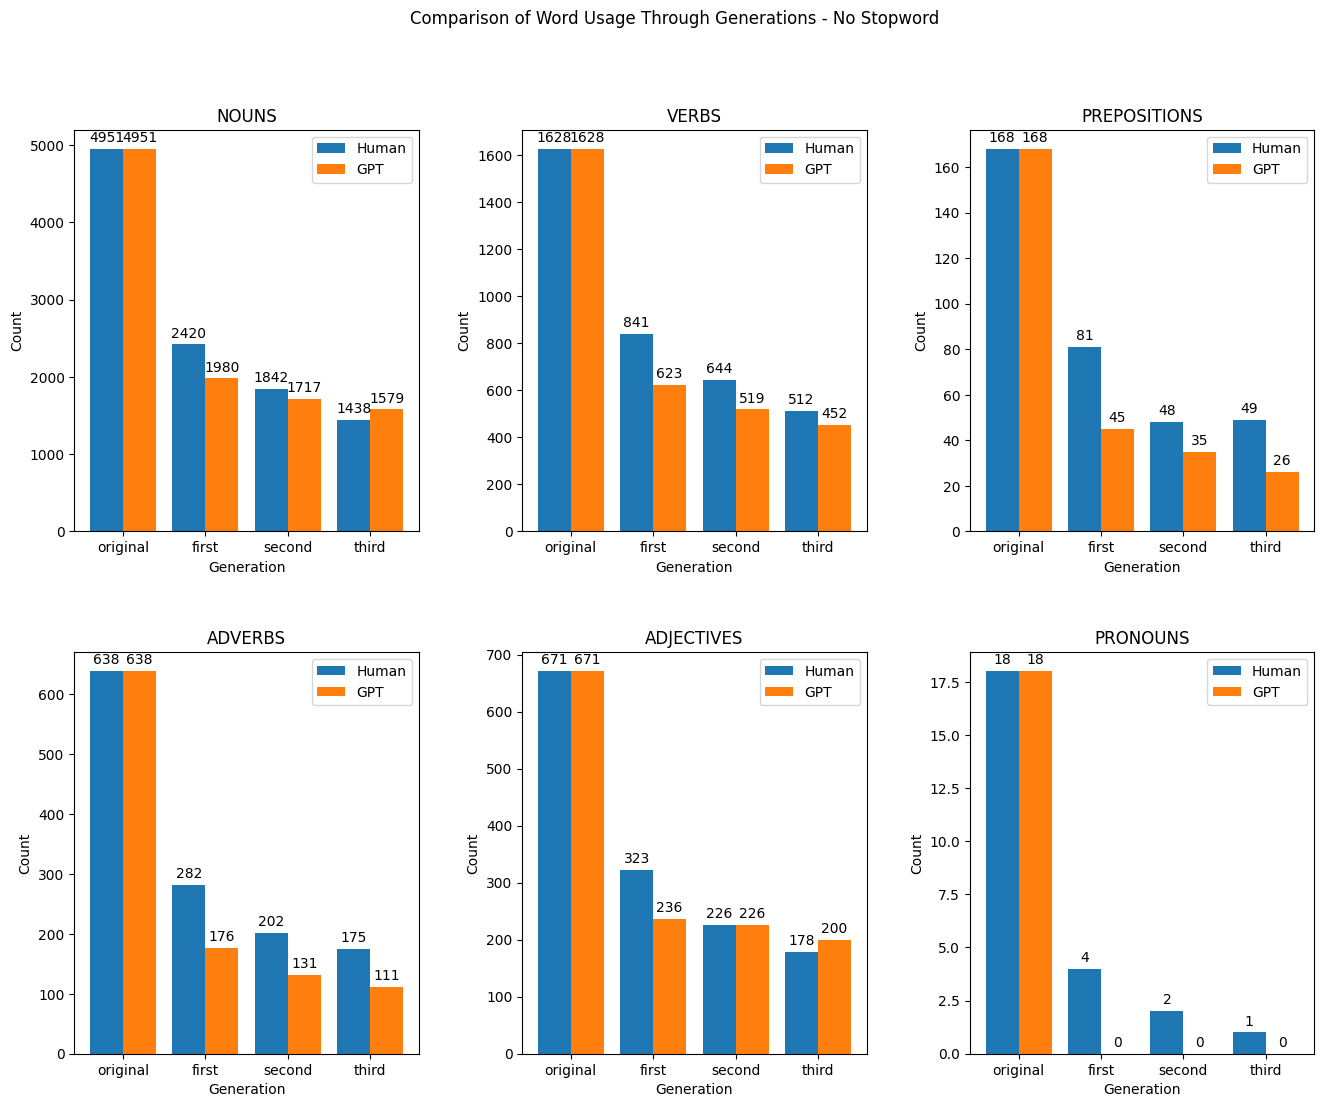

In [241]:
# Create some data
x = ['original', 'first','second','third']
y1 = Human['NOUNS']
y2 = GPT['NOUNS']

# Set the width of each bar
bar_width = 0.40

# Create the bar plot
fig, axs = plt.subplots(2, 3)
rects1 = axs[0,0].bar(x, y1, bar_width, label='Human')
rects2 = axs[0,0].bar([i + bar_width for i in range(len(x))], y2, bar_width, label='GPT')

# Add labels and a legend
axs[0,0].set_xlabel('Generation')
axs[0,0].set_ylabel('Count')
axs[0,0].set_title('NOUNS')
axs[0,0].set_xticks([i + bar_width/2 for i in range(len(x))])
axs[0,0].set_xticklabels(x)
axs[0,0].legend()

# Add text on top of each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        axs[0,0].annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# Create some data
x = ['original', 'first','second','third']
y1 = Human['VERBS']
y2 = GPT['VERBS']

# Set the width of each bar
bar_width = 0.40

# Create the bar plot
rects1 = axs[0,1].bar(x, y1, bar_width, label='Human')
rects2 = axs[0,1].bar([i + bar_width for i in range(len(x))], y2, bar_width, label='GPT')

# Add labels and a legend
axs[0,1].set_xlabel('Generation')
axs[0,1].set_ylabel('Count')
axs[0,1].set_title('VERBS')
axs[0,1].set_xticks([i + bar_width/2 for i in range(len(x))])
axs[0,1].set_xticklabels(x)
axs[0,1].legend()

# Add text on top of each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        axs[0,1].annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)



# Create some data
x = ['original', 'first','second','third']
y1 = Human['ADJECTIVES']
y2 = GPT['ADJECTIVES']

# Set the width of each bar
bar_width = 0.40

# Create the bar plot
rects1 = axs[1,1].bar(x, y1, bar_width, label='Human')
rects2 = axs[1,1].bar([i + bar_width for i in range(len(x))], y2, bar_width, label='GPT')

# Add labels and a legend
axs[1,1].set_xlabel('Generation')
axs[1,1].set_ylabel('Count')
axs[1,1].set_title('ADJECTIVES')
axs[1,1].set_xticks([i + bar_width/2 for i in range(len(x))])
axs[1,1].set_xticklabels(x)
axs[1,1].legend()

# Add text on top of each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        axs[1,1].annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# Create some data
x = ['original', 'first','second','third']
y1 = Human['ADVERBS']
y2 = GPT['ADVERBS']

# Set the width of each bar
bar_width = 0.40

# Create the bar plot
rects1 = axs[1,0].bar(x, y1, bar_width, label='Human')
rects2 = axs[1,0].bar([i + bar_width for i in range(len(x))], y2, bar_width, label='GPT')

# Add labels and a legend
axs[1,0].set_xlabel('Generation')
axs[1,0].set_ylabel('Count')
axs[1,0].set_title('ADVERBS')
axs[1,0].set_xticks([i + bar_width/2 for i in range(len(x))])
axs[1,0].set_xticklabels(x)
axs[1,0].legend()

# Add text on top of each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        axs[1,0].annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.set_size_inches(16, 12)

plt.subplots_adjust(wspace=0.3, hspace=0.3)
fig.suptitle('Comparison of Word Usage Through Generations - No Stopword')

# prepositions
x = ['original', 'first','second','third']
y1 = Human['PREPOSITION']
y2 = GPT['PREPOSITION']

# Set the width of each bar
bar_width = 0.40

# Create the bar plot
rects1 = axs[0,2].bar(x, y1, bar_width, label='Human')
rects2 = axs[0,2].bar([i + bar_width for i in range(len(x))], y2, bar_width, label='GPT')

# Add labels and a legend
axs[0,2].set_xlabel('Generation')
axs[0,2].set_ylabel('Count')
axs[0,2].set_title('PREPOSITIONS')
axs[0,2].set_xticks([i + bar_width/2 for i in range(len(x))])
axs[0,2].set_xticklabels(x)
axs[0,2].legend()

# Add text on top of each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        axs[0,2].annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)


# pronouns
x = ['original', 'first','second','third']
y1 = Human['PRONOUN']
y2 = GPT['PRONOUN']

# Set the width of each bar
bar_width = 0.40

# Create the bar plot
rects1 = axs[1,2].bar(x, y1, bar_width, label='Human')
rects2 = axs[1,2].bar([i + bar_width for i in range(len(x))], y2, bar_width, label='GPT')

# Add labels and a legend
axs[1,2].set_xlabel('Generation')
axs[1,2].set_ylabel('Count')
axs[1,2].set_title('PRONOUNS')
axs[1,2].set_xticks([i + bar_width/2 for i in range(len(x))])
axs[1,2].set_xticklabels(x)
axs[1,2].legend()

# Add text on top of each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        axs[1,2].annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# Show the plot
plt.show


## 3.4. Visualize Numbers

In [218]:
x = ['original', 'first','second','third']
y1 = Human['NUMBERS']
y2 = GPT['NUMBERS']

fig, ax = plt.subplots()



# Create the bar plot
rects1 = ax.bar(x, y1, bar_width, label='Human')
rects2 = ax.bar([i + bar_width for i in range(len(x))], y2, bar_width, label='GPT')

# Add labels and a legend
ax.set_xlabel('Generation')
ax.set_ylabel('Count')
ax.set_title('NUMBERS')
ax.set_xticks([i + bar_width/2 for i in range(len(x))])
ax.set_xticklabels(x)
ax.legend()

# Add text on top of each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)



KeyError: 'NUMBERS'